* 投手ごとにjaccard係数を測ってクラスタリングしたコード

In [16]:
import pandas as pd
df = pd.read_csv('df_clean_zone_cluster.csv')

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import MDS

# === 1. ピッチャーごとの主要球種リストを集計 ===
pitcher_top_pitches = []

for pitcher, group in df.groupby('pitcher'):
    pitch_counts = group['pitch_type'].value_counts(normalize=True).sort_values(ascending=False)
    cumulative = pitch_counts.cumsum()
    selected = cumulative[cumulative <= 0.80].index.tolist()
    if len(selected) < len(pitch_counts):
        selected.append(cumulative[cumulative > 0.80].index[0])
    pitcher_top_pitches.append({'pitcher': pitcher, 'major_pitch_types': list(selected)})

top_pitch_df = pd.DataFrame(pitcher_top_pitches).set_index('pitcher')

# === 2. Jaccard 類似度行列の構築（setを使わない） ===
pitchers = top_pitch_df.index.tolist()
all_pitch_types = sorted(set(p for sublist in top_pitch_df['major_pitch_types'] for p in sublist))

binary_matrix = pd.DataFrame(0, index=pitchers, columns=all_pitch_types)

for pitcher in pitchers:
    for pt in top_pitch_df.loc[pitcher, 'major_pitch_types']:
        binary_matrix.loc[pitcher, pt] = 1

# Jaccard距離 = 1 - 類似度
intersection = np.dot(binary_matrix.values, binary_matrix.values.T)
row_sums = binary_matrix.sum(axis=1).values.reshape(-1, 1)
union = row_sums + row_sums.T - intersection
jaccard_similarity = intersection / union
jaccard_distance = 1 - jaccard_similarity
np.fill_diagonal(jaccard_distance, 0)

jaccard_distance


array([[0.        , 1.        , 0.75      , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.        , 0.75      , ..., 0.66666667, 0.        ,
        0.5       ],
       [0.75      , 0.75      , 0.        , ..., 1.        , 0.75      ,
        0.83333333],
       ...,
       [1.        , 0.66666667, 1.        , ..., 0.        , 0.66666667,
        0.5       ],
       [1.        , 0.        , 0.75      , ..., 0.66666667, 0.        ,
        0.5       ],
       [1.        , 0.5       , 0.83333333, ..., 0.5       , 0.5       ,
        0.        ]])

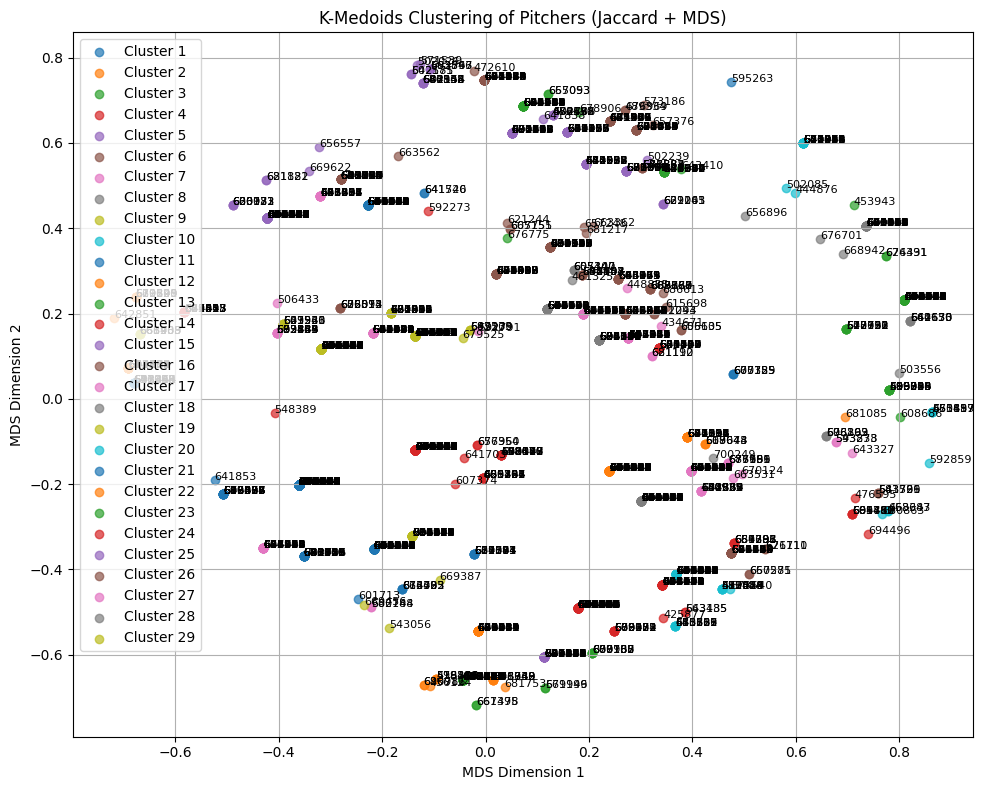

In [18]:

# === 4. K-Medoids クラスタリング ===
k = 29  # 任意のクラスタ数
kmedoids = KMedoids(n_clusters=k, metric='precomputed',method='pam', random_state=0)
kmedoids.fit(jaccard_distance)  # 学習
labels = kmedoids.labels_       # クラスタラベルを取得

# === 3. MDS（次元圧縮） ===
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
coords = mds.fit_transform(jaccard_distance)

# === 5. 可視化 ===
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(coords[labels == i, 0], coords[labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)

# ピッチャー名をラベルに
for i, name in enumerate(pitchers):
    plt.text(coords[i, 0], coords[i, 1], name, fontsize=8)

plt.title("K-Medoids Clustering of Pitchers (Jaccard + MDS)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
!pip install adjustText


Defaulting to user installation because normal site-packages is not writeable


In [20]:
pitcher_cluster_df = pd.DataFrame({
    'pitcher': pitchers,
    'pitcher_cluster': labels
})
df = df.merge(pitcher_cluster_df, on='pitcher', how='left')  # 投球ごとにクラスタを付ける


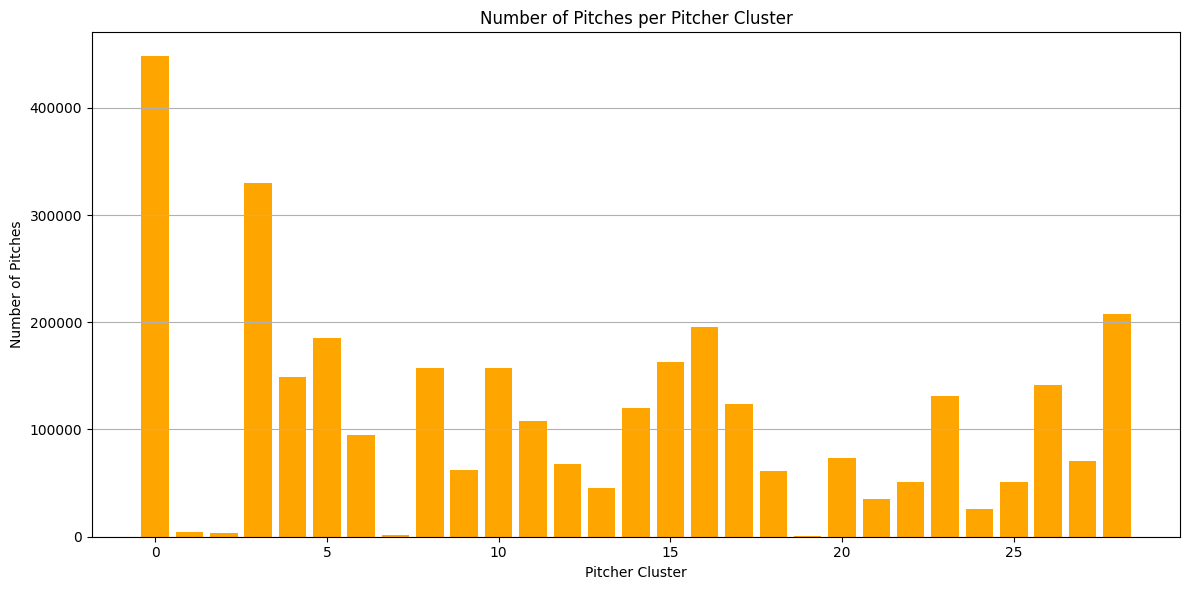

In [21]:
df_counts = df.groupby('pitcher_cluster').size().reset_index(name='投球数')

plt.figure(figsize=(12, 6))
plt.bar(df_counts['pitcher_cluster'], df_counts['投球数'], color='orange')
plt.xlabel('Pitcher Cluster')
plt.ylabel('Number of Pitches')
plt.title('Number of Pitches per Pitcher Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


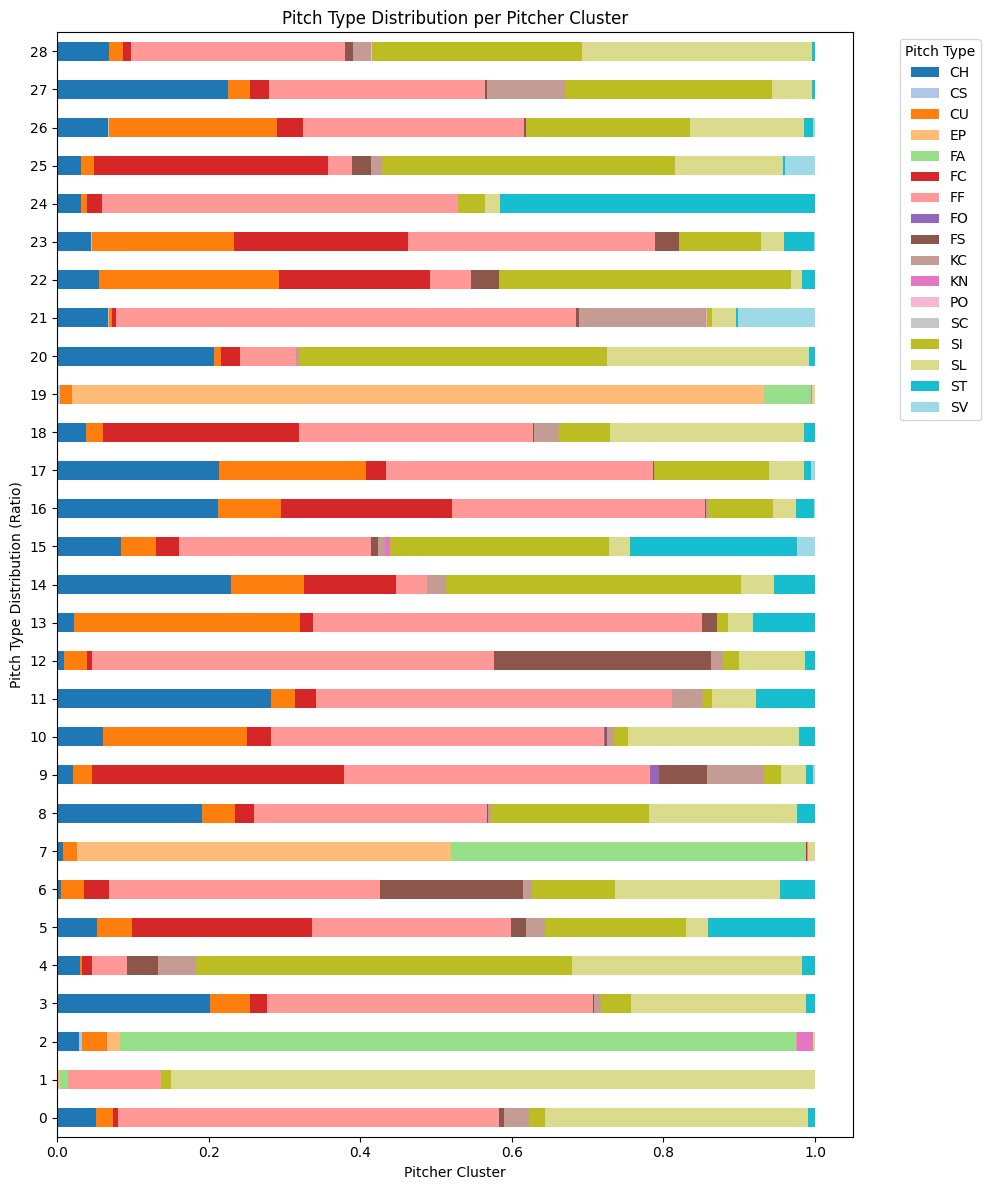

In [22]:
# 球種の出現割合をクラスタごとに見る
pitch_dist = pd.crosstab(df['pitcher_cluster'], df['pitch_type'], normalize='index')

# 上位数球種だけ見たければ
#top_pitches = df['pitch_type'].value_counts().nlargest(10).index

#pitch_dist_top = pitch_dist[top_pitches]

# グラフ表示
pitch_dist.plot(kind='barh', stacked=True, figsize=(10, 12), colormap='tab20')
plt.xlabel('Pitcher Cluster')
plt.ylabel('Pitch Type Distribution (Ratio)')
plt.title('Pitch Type Distribution per Pitcher Cluster')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


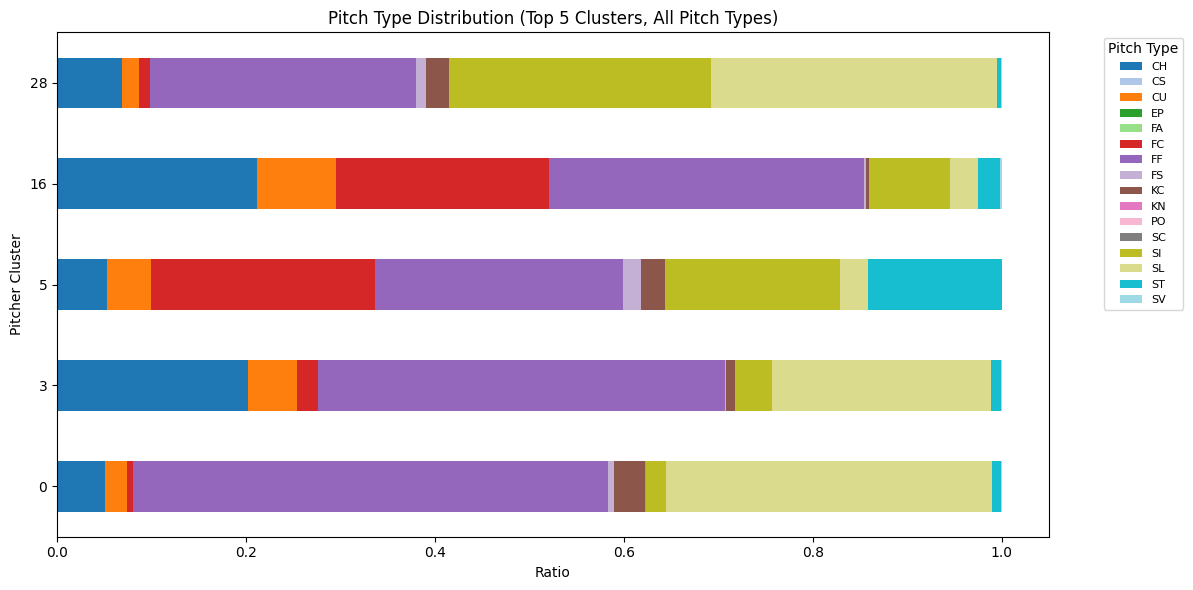

In [23]:
# "Other" なし、全ての球種を対象とした上位5クラスタの球種構成の可視化
top_clusters = df['pitcher_cluster'].value_counts().nlargest(5).index
df_top = df[df['pitcher_cluster'].isin(top_clusters)]

# 上位5クラスタでのクロス集計（全球種、割合）
pitch_dist_all_pitches = pd.crosstab(df_top['pitcher_cluster'], df_top['pitch_type'], normalize='index')

# 積み上げ横棒グラフ
pitch_dist_all_pitches.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='tab20')
plt.xlabel('Ratio')
plt.ylabel('Pitcher Cluster')
plt.title('Pitch Type Distribution (Top 5 Clusters, All Pitch Types)')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()